<a href="https://colab.research.google.com/github/FSNLSTR/PythonProjects/blob/main/MLSP_Project04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import librosa as lb
import numpy as np
import pandas as pd
from IPython.display import Audio

**Problem #1**

In [ ]:
piano_clap, sr = lb.load('Piano_Clap.wav', sr = None)
piano_clap.shape

(154184,)

In [ ]:
Audio(piano_clap, rate = sr)

In [ ]:
mfcc = scipy.io.loadmat('mfcc.mat')
mfcc = mfcc['X']
mfcc.shape

(12, 962)

In [ ]:
musigma = scipy.io.loadmat('MuSigma.mat')
print(musigma['mX'].shape)
print(musigma['Sigma'].shape)

(12, 2)
(12, 12, 2)


In [ ]:
muPiano = musigma['mX'][:,0]
muClaps = musigma['mX'][:,1]

covPiano = musigma['Sigma'][:,:,0]
covClaps = musigma['Sigma'][:,:,1]

print(muPiano.shape, muClaps.shape)
print(covPiano.shape, covClaps.shape)

(12,) (12,)
(12, 12) (12, 12)


In [ ]:
def gaussian(x, mu, cov):
  pdf = []
  for i in range(x.shape[1]):
    x_vector = x[:,i].reshape(1,-1)
    n_constant = (1 / np.power(2 * np.pi, (cov.shape[0])/2)) * np.power(np.linalg.det(cov), -0.5)
    pdf.append(n_constant * np.exp((-0.5) * np.dot(np.dot((x_vector-mu), np.linalg.inv(cov)), (x_vector-mu).T)))

  return np.array(pdf).reshape(-1,)


p = np.array([gaussian(mfcc, muPiano, covPiano), gaussian(mfcc, muClaps, covClaps)])
p /= p.sum(axis = 0).reshape(1, -1)
p.shape

(2, 962)

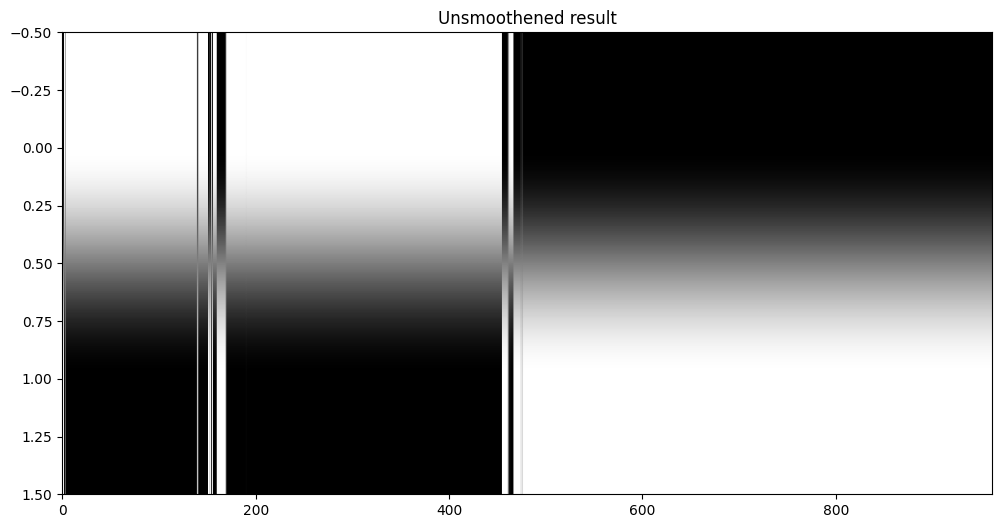

In [ ]:
plt.figure(figsize = (12,6))
plt.title('Unsmoothened result')
plt.imshow(p, cmap='gray', aspect ='auto')
plt.show()

In [ ]:
T = np.array([[0.9,0.1],[0,1]])
pBar = np.array(p)

for i in range(p.shape[1]-1):
  pBar[:,i+1] = T[np.argmax(pBar[:,i]),:] * p[:,i+1]
  pBar[:,i+1] = pBar[:,i+1]/np.sum(pBar[:,i+1])

pBar.shape

(2, 962)

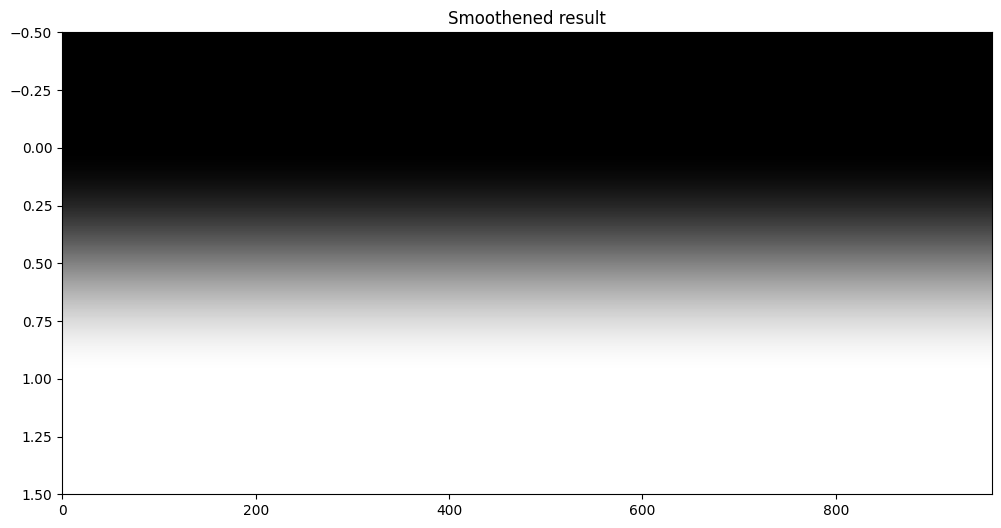

In [ ]:
plt.figure(figsize= (12,6))
plt.title('Smoothened result')
plt.imshow(pBar, cmap='gray', aspect ='auto')
plt.show()

In [ ]:
pBar_v = np.array(p)
b = np.zeros(p.shape)

for i in range(p.shape[1]-1):
  b0, b1 = np.argmax(T[:,0] * pBar_v[:,i]), np.argmax(T[:,1] * pBar_v[:,i])
  b[0,i+1], b[1,i+1] = b0, b1

  pBar_v[0,i+1] = T[b0,0] * pBar_v[b0,i] * p[0,i+1]
  pBar_v[1,i+1] = T[b1,1] * pBar_v[b1,i] * p[1,i+1]
  pBar_v[:,i+1] = pBar_v[:,i+1]/np.sum(pBar_v[:,i+1])

for i in range(b.shape[1]-1):
  b_prev = int(b[np.argmax(pBar_v[:, p.shape[1]-1-i]), p.shape[1]-1-i])
  pBar_v[b_prev, p.shape[1]-1-i-1] = 1
  pBar_v[1-b_prev, p.shape[1]-1-i-1] = 0

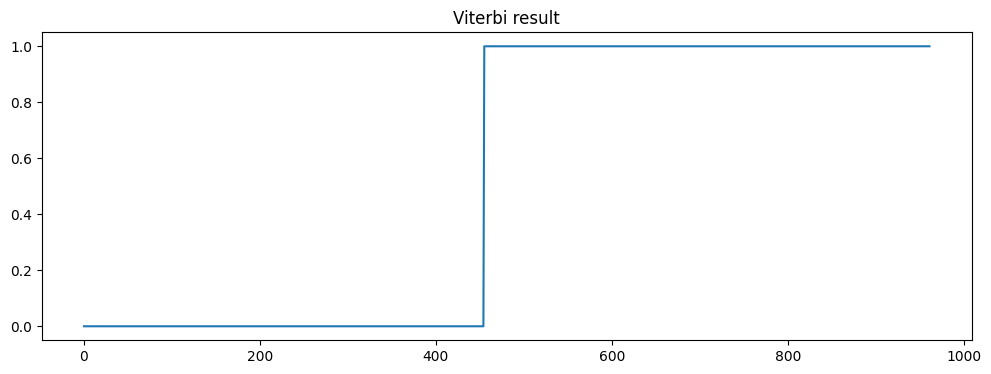

In [ ]:
plt.figure(figsize= (12,4))
plt.title('Viterbi result')
plt.plot(pBar_v[1,:])
plt.show()

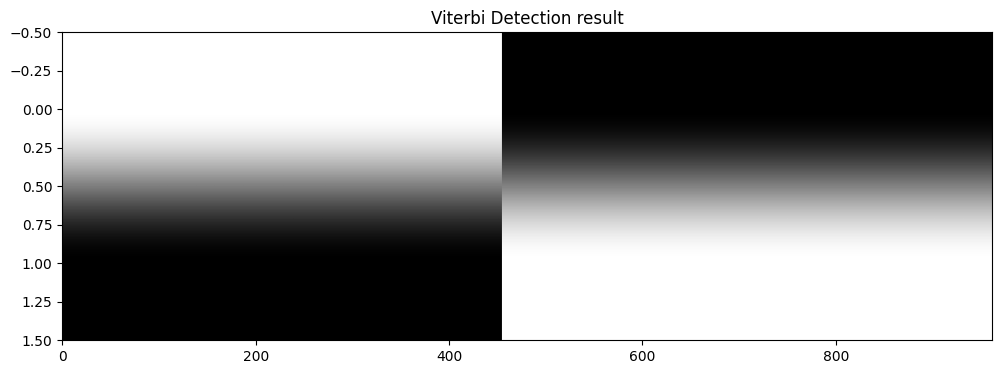

In [ ]:
plt.figure(figsize= (12,4))
plt.title('Viterbi Detection result')
plt.imshow(pBar_v, cmap='gray', aspect ='auto')
plt.show()

**Problem #2**

In [ ]:
mds = scipy.io.loadmat('mds.mat')
mds

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar  1 14:07:22 2024',
 '__version__': '1.0',
 '__globals__': [],
 'L': array([[  0.        , 253.55275585, 231.95258136, ..., 208.80613018,
          71.86793444, 243.68011819],
        [253.55275585,   0.        ,  79.0253124 , ...,  69.28924881,
         198.86176103,  32.01562119],
        [231.95258136,  79.0253124 ,   0.        , ..., 120.73938877,
         197.1014967 ,  47.09564736],
        ...,
        [208.80613018,  69.28924881, 120.73938877, ...,   0.        ,
         144.46106742,  86.55634003],
        [ 71.86793444, 198.86176103, 197.1014967 , ..., 144.46106742,
           0.        , 196.12496017],
        [243.68011819,  32.01562119,  47.09564736, ...,  86.55634003,
         196.12496017,   0.        ]])}

In [ ]:
mds_mat = mds['L']
mds_mat.shape

(2037, 2037)

In [ ]:
# Number of data points
n = mds_mat.shape[0]
n

2037

In [ ]:
# Step 1: Compute double centered matrix
H = np.eye(n) - np.ones((n, n)) / n
B = -0.5 * H @ mds_mat @ H
print(H.shape, B.shape)

(2037, 2037) (2037, 2037)


In [ ]:
# Step 2: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(B)
print(eigenvalues.shape, eigenvectors.shape)

(2037,) (2037, 2037)


In [ ]:
# Step 3: Select two largest eigenvectors
largest_indices = np.argsort(eigenvalues)[::-1][:2]
lower_diag = np.diag(np.sqrt(np.abs(eigenvalues[largest_indices])))
largest_eigenvectors = eigenvectors[:, largest_indices]

# Step 4: Form low-dimensional representation
L = largest_eigenvectors @ lower_diag
L.shape

(2037, 2)

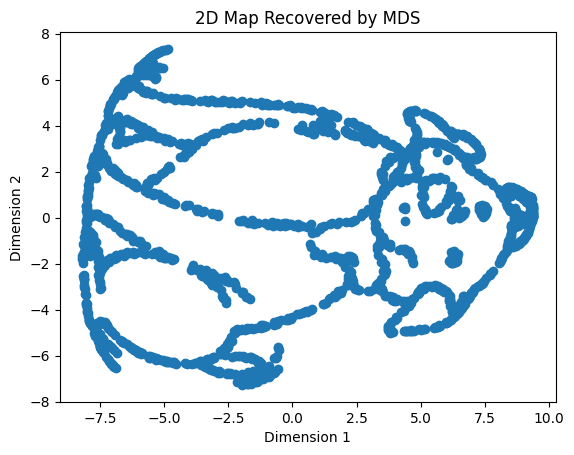

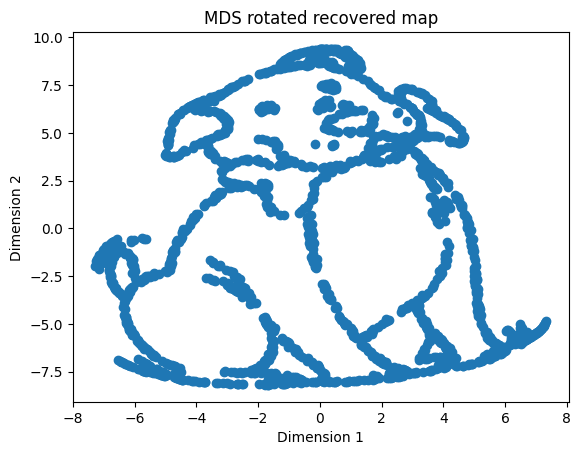

In [ ]:
# Step 5: Plot the samples in the low-dimensional space
plt.scatter(L[:, 0], L[:, 1])
plt.title('2D Map Recovered by MDS')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

plt.title('MDS rotated recovered map')
plt.scatter(L[:,1], L[:,0])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

**Problem 3**

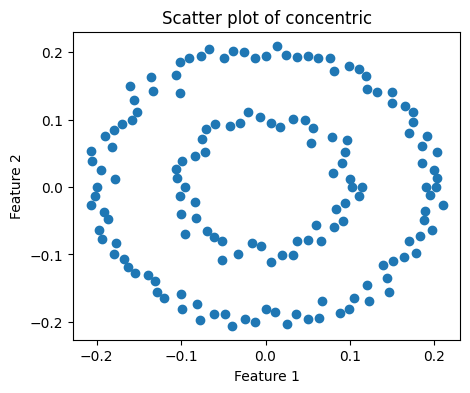

In [ ]:
concentric = scipy.io.loadmat('concentric.mat')
concentric = concentric['X']
c_count = concentric.shape[1]

plt.figure(figsize= (5,4))
plt.title('Scatter plot of concentric')
plt.scatter(concentric[0,:], concentric[1,:],)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
def rbf_kernel(i,j):
    return np.exp(-np.sum((i - j)**2)/0.01)

def logistic(x):
    return 1/(1 + np.exp(-x))

def eigen_decomp(X, num_eigenvectors):
    eigen_val, eigen_vec = np.linalg.eig(X)
    idx = np.argsort(eigen_val)[::-1][:num_eigenvectors]
    eigen_vec = eigen_vec[:, idx]
    eigen_val = eigen_val[idx]
    return eigen_vec, eigen_val

kernel = np.array([[rbf_kernel(concentric[:, i], concentric[:, j]) for i in range(c_count)] for j in range(c_count)])
eigen_vec, _ = eigen_decomp(kernel, 3)
eigen_vec = eigen_vec.T
eigen_vec.shape

(3, 152)

In [ ]:
X = np.concatenate((eigen_vec, np.ones(eigen_vec.shape[1]).reshape(1,-1)), axis=0)
Y = np.array([int(i > 50) for i in range(152)])

print(X.shape, Y.shape)

(4, 152) (152,)


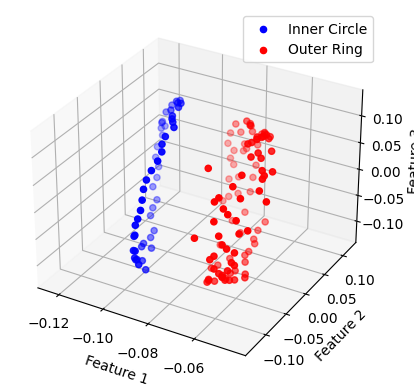

In [ ]:
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0, Y == 0], X[1, Y == 0], X[2, Y == 0], c='b', label='Inner Circle')
ax.scatter(X[0, Y == 1], X[1, Y == 1], X[2, Y == 1], c='r', label='Outer Ring')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.legend()
plt.show()

In [ ]:
W = np.random.uniform(0, 1, size=4).reshape(-1, 1)
error_plot = []
max_epochs = 100000
epoch = 0
alpha = 0.1

for epoch in range(max_epochs):
  prediction = logistic(np.dot(W.T, X))
  error = 0.5 * np.sum((Y - prediction) ** 2)
  error_plot.append(error)
  delta_W = np.dot(X, ((prediction - Y) * prediction * (1 - prediction)).T)
  W -= alpha * delta_W


Y_hat = logistic(np.dot(W.T, X))
error = 0.5 * (np.dot((Y-Y_hat),(Y-Y_hat).T))**2

print('Weights of the perceptron are: ' + str(W.flatten()))
print('Error is: ' + str(error[0][0]))

Weights of the perceptron are: [192.32777319  25.07214518  -7.86959709  17.1234441 ]
Error is: 0.06360531070633554


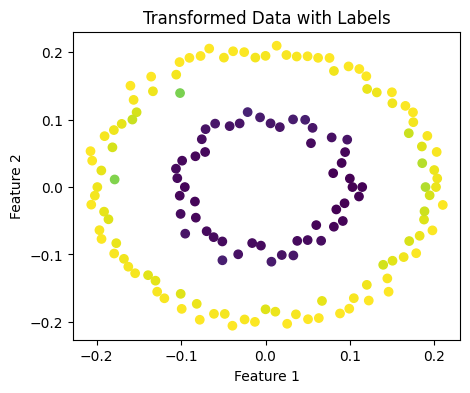

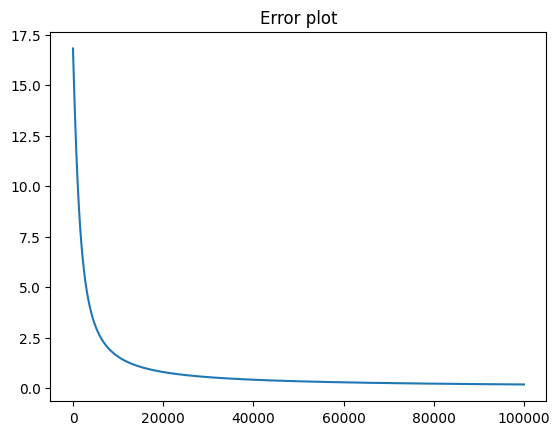

In [ ]:
plt.figure(figsize= (5,4))
plt.title('Transformed Data with Labels')
plt.scatter(concentric[0,:], concentric[1,:], c=Y_hat, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

plt.title('Error plot')
plt.plot(np.array(error_plot).reshape(max_epochs,1))
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html ///content/MLSP_Project04.ipynb

[NbConvertApp] Converting notebook ///content/MLSP_Project04.ipynb to html
[NbConvertApp] Writing 1481583 bytes to /content/MLSP_Project04.html
